In [3]:
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import sys, os
import copy
import seaborn as sns
from copy import deepcopy
import scipy.stats

# Summary 
## Experimental Design

This in the analysis of the data gathered by the Stimulus pre-test.
The general structure of the experiment was as follows:
Participants were presented with lists of stimuli pairs and had to learn which pairs are classified as "valid" and which as "invalid". 
It includes 1 baseline and 3 experimental conditions.

In the "baseline" condition, participants had to learn to classify 6 pairs of 4-letter non-words.

In the "visual" condition, participants had to learn to classify 6 pairs of shapes and 4-letter non-words.

In the "distractor" condition, participants had to learn to classify 6 pairs of 4-letter non-words, for which the invaid 
pairs were novel combinations of the words forming the valid pairs (as opposed to one word from the valid pair pool and one completely new one).

In the "Setsize" condition, participants had to learn to classify 10 pairs of shapes and 4-letter non-words.

In each condition, half of the stimuli pairs were "valid" and the other half "invalid". 

## Results 

With data gathered from 57 participants, the follwoing was found: 
1. No significant differences in accuracy (% of Correct Responses) between the Baseline and any of the Experimental Conditions
2. Significant difference in accuracy between valid and invalid stimulus pair --> participants show a preference for repsonding "valid"
3. Significant difference in accuracy between second trial (after receiving the first feed-back) and 5th trial only in the visual condition. 
4. Inspecting accuracy development for each participants show that most of the participants that do manage to learn the list do that early on (often in the first trial after feedback). 


## Discussion 

1. Interventions trying to manipulate difficulty were unsuccesful
2. Overall performance lower that inspected, ceiling effect for a small sub-group
3. Participants preference for responding with valid is in line with other empirical findings, namely "agreement bias". 
   Mostly described in the context of surveys, but this paper "Correct acceptance weighs more than correct rejection: a decision bias induced by question framing" explores it for prediction. 
   
  
## Conclusion 

We could exploit the general tendency to respond with "valid" rather than "inavlid" for the pilot study.
If game A presents more valid pairs than game B, than the average participant would receive more reward from game A if the reward is performance based. 

It would be easy to adapt the Stimuli pretest to test different valid-invalid ratios. 





# Prepare Data
## Read In 

In [4]:
path = "ExperimentData.json"
data = json.load(open(path))

df_index = ["Participant", "Condition", "TrialId", "Trial_Type","Trialtime","Key", "ResponseTime",  "Correct_Response", "Block","Associated", "Stimulus_ID", "RT"]
df_data = []


N_TEST_TRIALS = 0
complete_responses = 0

for participant_index, participant_data in enumerate(data["values"]):
    
    response_data = participant_data[-1]
    if response_data != None:
        response = json.loads(response_data)
        #print(response)
        condition = response["condition"]
        participant = response["workerId"]
        timestamp = participant_data[11]
        data = response["data"]
        #checker.append(data)
        participant_responses = []
        if len(data) > 0:
            for trial in data:
                trial_id = trial["current_trial"]
                trial_data = trial["trialdata"]
                trial_time = trial['dateTime']
                trial_type = trial_data["trial_type"]
                ## attention check trials ##
                if trial_data["trial_type"] == "html-keyboard-response" and "correct" in trial_data.keys():
                    key = trial_data["key_press"]
                    time = trial_data["time_elapsed"]
                    correct = trial_data["correct"]
                    block = trial_data["block_type"]
                    
                    participant_responses.append([participant, condition, trial_id,trial_type,trial_time, key, time, correct, block])
                    
                ## instruction / break trials ##
                elif trial_data["trial_type"] == "html-keyboard-response":
                    key = trial_data["key_press"]
                    time = trial_data["time_elapsed"]
                    participant_responses.append([participant, condition, trial_id,trial_type,trial_time, key, time])
                    
                ## learning trials ## 
                elif trial_data["trial_type"] == "categorize-html":
                    
                    key = trial_data["key_press"]
                    time = trial_data["time_elapsed"]
                    associated = trial_data["associated_pair"]
                    correct = trial_data["correct"]
                    block = trial_data["block_type"]
                    stimulus_id = trial_data["stimulus_id"]
                    rt = trial_data["rt"]
                    participant_responses.append([participant, condition, trial_id,trial_type, trial_time,key, time, correct, block, associated, stimulus_id,rt])
                else:
                    print(trial_data["trial_type"])
        if len(participant_responses) > N_TEST_TRIALS and participant != "debug1Wqw5" :
            complete_responses += 1
            for d in participant_responses:
                df_data.append(d)

print("Complete responses", complete_responses)
df = pd.DataFrame(df_data, columns=df_index)
df["Trialtime"] = df["Trialtime"].astype("datetime64[ms]")
df.head()

Complete responses 57


,Participant,Condition,TrialId,Trial_Type,Trialtime,Key,ResponseTime,Correct_Response,Block,Associated,Stimulus_ID,RT
0,debug6LTBd,0,0,html-keyboard-response,2021-08-04 08:00:44.443,32,1232,None,None,None,None,NaN
1,debug6LTBd,0,1,html-keyboard-response,2021-08-04 08:01:36.744,32,53533,None,None,None,None,NaN
2,debug6LTBd,0,2,html-keyboard-response,2021-08-04 08:01:44.326,32,61115,None,None,None,None,NaN
3,debug6LTBd,0,3,categorize-html,2021-08-04 08:01:49.331,74,66119,True,Baseline,False,base3,2138.0
4,debug6LTBd,0,4,categorize-html,2021-08-04 08:01:58.303,70,75092,True,Baseline,True,base1,4650.0


## Filter by Attention Check Trials

In [5]:
x = df[df["Block"]=="AttentionCheck"]
x = x[x["Correct_Response"]== False]
y = x.groupby("Participant").size()
print(y)
attention_filter = y[y>1]
print(attention_filter)

mask = df["Participant"].isin(attention_filter.index)
print(mask)
df = df[~mask]
len(df["Participant"].unique())
df.head()

Participant
debug8eefY    1
debugBBjRB    1
debugD4pn1    1
debugGBeMS    2
debugK5jRJ    1
debugUgTKf    1
debugXLBVg    1
dtype: int64
Participant
debugGBeMS    2
dtype: int64
0       False
1       False
2       False
3       False
4       False
        ...  
4174    False
4175    False
4176    False
4177    False
4178    False
Name: Participant, Length: 4179, dtype: bool


,Participant,Condition,TrialId,Trial_Type,Trialtime,Key,ResponseTime,Correct_Response,Block,Associated,Stimulus_ID,RT
0,debug6LTBd,0,0,html-keyboard-response,2021-08-04 08:00:44.443,32,1232,None,None,None,None,NaN
1,debug6LTBd,0,1,html-keyboard-response,2021-08-04 08:01:36.744,32,53533,None,None,None,None,NaN
2,debug6LTBd,0,2,html-keyboard-response,2021-08-04 08:01:44.326,32,61115,None,None,None,None,NaN
3,debug6LTBd,0,3,categorize-html,2021-08-04 08:01:49.331,74,66119,True,Baseline,False,base3,2138.0
4,debug6LTBd,0,4,categorize-html,2021-08-04 08:01:58.303,70,75092,True,Baseline,True,base1,4650.0


In [6]:
x

,Participant,Condition,TrialId,Trial_Type,Trialtime,Key,ResponseTime,Correct_Response,Block,Associated,Stimulus_ID,RT
1548,debugGBeMS,1,21,html-keyboard-response,2021-08-04 08:47:26.634,74,236227,False,AttentionCheck,None,None,NaN
1581,debugGBeMS,1,54,html-keyboard-response,2021-08-04 08:48:44.818,74,314411,False,AttentionCheck,None,None,NaN
2331,debugBBjRB,0,54,html-keyboard-response,2021-08-04 08:51:41.186,74,469672,False,AttentionCheck,None,None,NaN
2485,debugK5jRJ,1,54,html-keyboard-response,2021-08-04 08:50:51.265,70,485787,False,AttentionCheck,None,None,NaN
2919,debugD4pn1,2,66,html-keyboard-response,2021-08-04 08:53:13.069,74,568324,False,AttentionCheck,None,None,NaN
3369,debug8eefY,0,54,html-keyboard-response,2021-08-04 08:48:28.862,74,201122,False,AttentionCheck,None,None,NaN
3878,debugXLBVg,0,54,html-keyboard-response,2021-08-04 08:52:00.549,74,381174,False,AttentionCheck,None,None,NaN
3912,debugUgTKf,1,21,html-keyboard-response,2021-08-04 09:47:57.813,70,116028,False,AttentionCheck,None,None,NaN


## Add the Variable "Number of Times Stimulus has been previosuly encountered"

In [7]:
pd.set_option('display.min_rows', 140)
pd.set_option('display.max_rows', 250)
df["Nr_Pres"] = df.groupby(["Participant","Stimulus_ID"]).cumcount()
df[df["Trial_Type"]=="categorize-html"]["Nr_Pres"].unique()
df.head()

,Participant,Condition,TrialId,Trial_Type,Trialtime,Key,ResponseTime,Correct_Response,Block,Associated,Stimulus_ID,RT,Nr_Pres
0,debug6LTBd,0,0,html-keyboard-response,2021-08-04 08:00:44.443,32,1232,None,None,None,None,NaN,0
1,debug6LTBd,0,1,html-keyboard-response,2021-08-04 08:01:36.744,32,53533,None,None,None,None,NaN,1
2,debug6LTBd,0,2,html-keyboard-response,2021-08-04 08:01:44.326,32,61115,None,None,None,None,NaN,2
3,debug6LTBd,0,3,categorize-html,2021-08-04 08:01:49.331,74,66119,True,Baseline,False,base3,2138.0,0
4,debug6LTBd,0,4,categorize-html,2021-08-04 08:01:58.303,70,75092,True,Baseline,True,base1,4650.0,0


# Analyse effect of condition



## Overview Plots

In [8]:
def basic_plots(condition, labels):
    plt.figure(figsize=(12,4))
    c0 = df[df["Condition"]==condition]
    if labels[1] == "Setsize":
        plot_label = "Set Size"
    else:
        plot_label = labels[1]
    plt.subplot(1,2,1)
    plt.title("% correct responses per condition")
    plt.bar([labels[0], plot_label], [c0[c0["Block"]==labels[0]]["Correct_Response"].mean(),c0[c0["Block"]==labels[1]]["Correct_Response"].mean()], color=["#7fcdbb", '#2c7fb8'])
    
    plt.errorbar([labels[0], plot_label], [c0[c0["Block"]==labels[0]]["Correct_Response"].mean(),c0[c0["Block"]==labels[1]]["Correct_Response"].mean()], yerr=[c0[c0["Block"]==labels[0]]["Correct_Response"].std(),c0[c0["Block"]==labels[1]]["Correct_Response"].std()], fmt="o", color="k")
    plt.ylim(0,1.2)
    plt.yticks( [0,0.25,0.5,0.75,1.0],["0", "25","50","75","100"])
    plt.ylabel("Correct Responses[%]")
    plt.xlabel("Condition")
    plt.subplot(1,2,2)
    linedata = c0.groupby(["Block", "Nr_Pres"])["Correct_Response"].sum() / c0.groupby(["Block", "Nr_Pres"])["Correct_Response"].size()
    plt.title("% correct responses per condition and Nr. of encounters")
    plt.plot([x for x in range(0,5)],linedata[labels[0]][:], label = labels[0], color = "#7fcdbb", linestyle='--')
    
        
    plt.plot([x for x in range(0,5)],linedata[labels[1]][:], label = plot_label, color =  '#2c7fb8')
    plt.legend()
    plt.ylim(0,1.2)
    plt.yticks( [0,0.25,0.5,0.75,1.0],["0", "25","50","75","100"])
    plt.ylabel("Correct Responses[%]")
    plt.xticks([0,1,2,3,4])        
    plt.xlabel("Number of previous stimulus encounters")
    plt.suptitle(plot_label+" Condition", fontsize = 16)
    plt.show()
    


In [47]:
def make_boxplot(condition, labels):
    flierprops = dict(marker='o', markerfacecolor='k',markersize=1, linestyle='none')
    medianprops = dict(color = "k")
    plt.figure(figsize=(12,4))
    c0 = df[df["Condition"]==condition]
    if labels[1] == "Setsize":
        plot_label = "Set Size"
    else:
        plot_label = labels[1]
    plt.subplot(1,2,1)
    plt.title("% correct responses per condition")
    data0 = c0[c0["Block"]==labels[0]]["Correct_Response"].groupby(c0["Participant"]).sum() / c0[c0["Block"]==labels[0]]["Correct_Response"].groupby(c0["Participant"]).size()
    data1 = c0[c0["Block"]==labels[1]]["Correct_Response"].groupby(c0["Participant"]).sum() / c0[c0["Block"]==labels[1]]["Correct_Response"].groupby(c0["Participant"]).size()
    b = plt.boxplot([data0, data1], labels = labels,flierprops = flierprops,
                             patch_artist=True
                            , medianprops = medianprops
                            , whis = 100 )  
    colors = ["#7fcdbb", '#2c7fb8']
    for patch, color in zip(b['boxes'], colors):
        patch.set_facecolor(color)
        
    plt.yticks( [0,0.25,0.5,0.75,1.0],["0", "25","50","75","100"])
    plt.ylabel("Correct Responses[%]")
    plt.xlabel("Condition")
    plt.subplot(1,2,2)
    linedata = c0.groupby(["Block", "Nr_Pres"])["Correct_Response"].sum() / c0.groupby(["Block", "Nr_Pres"])["Correct_Response"].size()
    plt.title("% correct responses per condition and Nr. of encounters")
    plt.plot([x for x in range(0,5)],linedata[labels[0]][:], label = labels[0], color = "#7fcdbb", linestyle='--')
    
        
    plt.plot([x for x in range(0,5)],linedata[labels[1]][:], label = plot_label, color =  '#2c7fb8')
    plt.legend(loc="lower right")
    plt.ylim(0,1)
    plt.yticks( [0,0.25,0.5,0.75,1.0],["0", "25","50","75","100"])
    plt.ylabel("Correct Responses[%]")
    plt.xticks([0,1,2,3,4])        
    plt.xlabel("Number of previous stimulus encounters")
    #plt.suptitle(plot_label+" Condition ", fontsize = 16, y=1.05)
    plt.show()

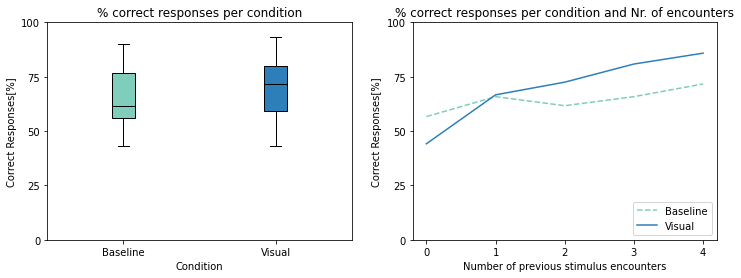

In [48]:
make_boxplot(0, ["Baseline", "Visual"])

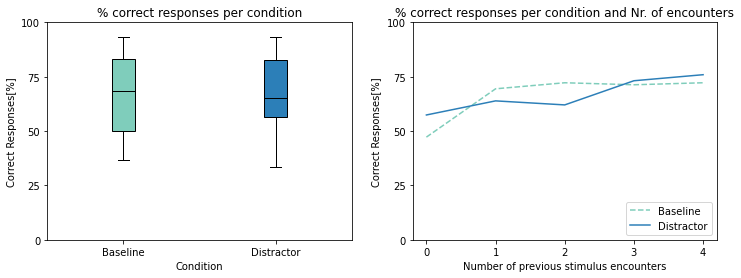

In [49]:
make_boxplot(1, ["Baseline", "Distractor"])

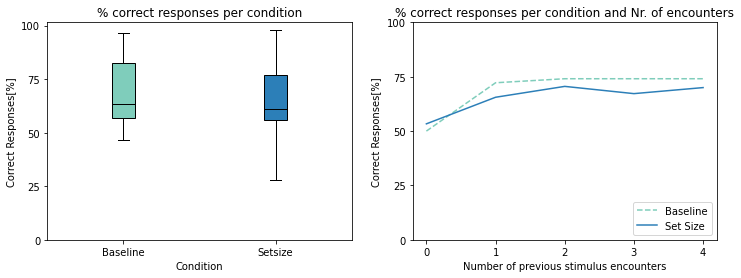

In [50]:
make_boxplot(2, ["Baseline", "Setsize"])

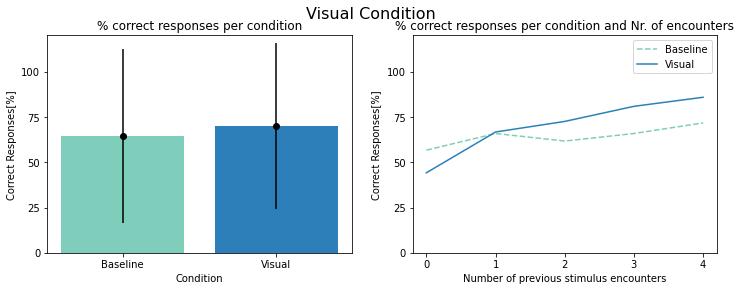

In [13]:
basic_plots(0, ["Baseline", "Visual"])

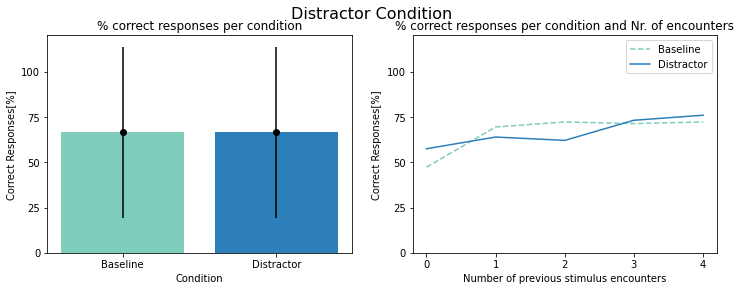

In [14]:
basic_plots(1, ["Baseline", "Distractor"])

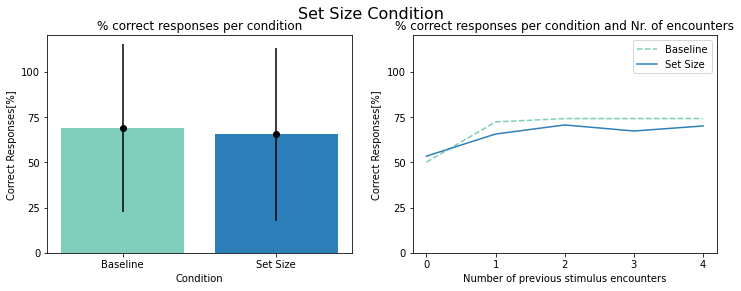

In [15]:
basic_plots(2, ["Baseline", "Setsize"])

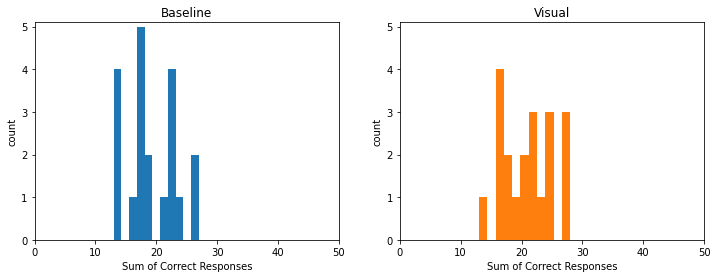

In [16]:
def basic_hist(condition, labels):
    plt.figure(figsize=(12,4))
    c0 = df[df["Condition"]==condition]
    plt.subplot(1,2,1)
    b = c0[c0["Block"]==labels[0]].groupby("Participant")["Correct_Response"].sum()
    x,y = np.histogram(b, bins = 11 ,density = False)
    plt.hist(b,bins = y)
    plt.ylim(0,5.1)
    plt.xlim(0,50)
    plt.title(labels[0])
    plt.xlabel("Sum of Correct Responses")
    plt.ylabel("count")
    plt.subplot(1,2,2)
    e = c0[c0["Block"]==labels[1]].groupby("Participant")["Correct_Response"].sum()
    x,y = np.histogram(e, bins = 11 ,density = False)
    plt.hist(e,bins = y, color = "tab:orange")
    plt.ylim(0,5.1)
    plt.xlim(0,50)
    plt.xlabel("Sum of Correct Responses")
    plt.ylabel("count")
    plt.title(labels[1])
    
basic_hist(0, ["Baseline", "Visual"])

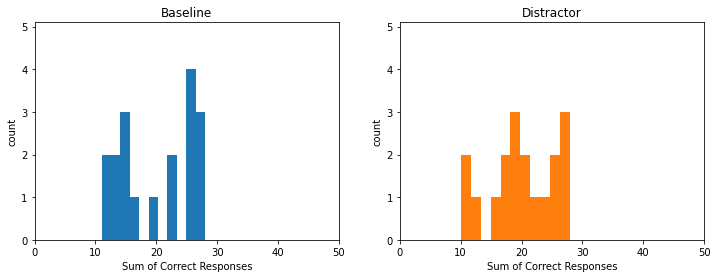

In [17]:
basic_hist(1, ["Baseline", "Distractor"])

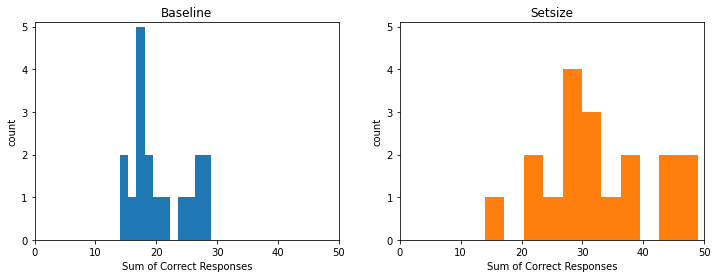

In [18]:
basic_hist(2, ["Baseline", "Setsize"])

## Results of Wilcoxon signed-rank test of performance in conditions

Differences in percentage of correct responses between the baseline and the experimental condition were tested for with the non-parametric Wilcoxon signed-rank test. For multiple testing, the p-value was adjusted according to the Bonferroni correction. 

No differences in performance between the Baseline and any of the experimental conditons were found. 

In [19]:
def get_wilcoxon_results(condition, labels):
    c0 = df[df["Condition"]==condition]
    x = c0[c0["Block"]== labels[0]].groupby("Participant")["Correct_Response"].sum() / c0[c0["Block"]== labels[0]].groupby("Participant")["Correct_Response"].size()
    print(scipy.stats.shapiro(x))
    y = c0[c0["Block"]== labels[1]].groupby("Participant")["Correct_Response"].sum() / c0[c0["Block"]== labels[1]].groupby("Participant")["Correct_Response"].size()
    print(scipy.stats.shapiro(y))
    print(scipy.stats.wilcoxon(x,y, mode = "approx"))
    print(scipy.stats.ttest_rel(x,y))

In [20]:
adjusted_p = 0.05/3
adjusted_p

0.016666666666666666

In [21]:
get_wilcoxon_results(0, ["Baseline", "Visual"])

ShapiroResult(statistic=0.9478038549423218, pvalue=0.33498018980026245)
ShapiroResult(statistic=0.9560492634773254, pvalue=0.46824270486831665)
WilcoxonResult(statistic=70.0, pvalue=0.31370264318987995)
Ttest_relResult(statistic=-1.4338006662122005, pvalue=0.16788209326123044)


In [22]:
get_wilcoxon_results(1, ["Baseline", "Distractor"])

ShapiroResult(statistic=0.8920982480049133, pvalue=0.04193083196878433)
ShapiroResult(statistic=0.9518899321556091, pvalue=0.4554307460784912)
WilcoxonResult(statistic=82.0, pvalue=0.8787080056701636)
Ttest_relResult(statistic=3.1309163900513086e-16, pvalue=0.9999999999999998)


In [23]:
get_wilcoxon_results(2, ["Baseline", "Setsize"]) 

ShapiroResult(statistic=0.9098507761955261, pvalue=0.08551395684480667)
ShapiroResult(statistic=0.9628300666809082, pvalue=0.6570573449134827)
WilcoxonResult(statistic=83.0, pvalue=0.9133009306692093)
Ttest_relResult(statistic=0.6283112574866614, pvalue=0.5381505659720034)


In [24]:
import math
t_df = df[df["Condition"]==0]
b_mean = t_df[t_df["Block"]=="Baseline"]["Correct_Response"].mean()
b_var = t_df[t_df["Block"]=="Baseline"]["Correct_Response"].var()
s_mean = t_df[t_df["Block"]=="Visual"]["Correct_Response"].mean()
s_var = t_df[t_df["Block"]=="Visual"]["Correct_Response"].var()
n1 = len(t_df[t_df["Block"]=="Baseline"])
n2 = len(t_df[t_df["Block"]=="Visual"])
s = math.sqrt( ((n1 - 1) * b_var + (n2 - 1) * s_var)/(n1+n2-2)  )

t_df = df[df["Condition"]==0]
d = ((b_mean - s_mean) / s)
d

-0.12078777210790329

In [25]:
t_df = df[df["Condition"]==1]
b_mean = t_df[t_df["Block"]=="Baseline"]["Correct_Response"].mean()
b_var = t_df[t_df["Block"]=="Baseline"]["Correct_Response"].var()
s_mean = t_df[t_df["Block"]=="Distractor"]["Correct_Response"].mean()
s_var = t_df[t_df["Block"]=="Distractor"]["Correct_Response"].var()
n1 = len(t_df[t_df["Block"]=="Baseline"])
n2 = len(t_df[t_df["Block"]=="Distractor"])
s = math.sqrt( ((n1 - 1) * b_var + (n2 - 1) * s_var)/(n1+n2-2)  )

t_df = df[df["Condition"]==1]
d = ((b_mean - s_mean) / s)
d

0.0

In [26]:
t_df = df[df["Condition"]==2]
b_mean = t_df[t_df["Block"]=="Baseline"]["Correct_Response"].mean()
b_var = t_df[t_df["Block"]=="Baseline"]["Correct_Response"].var()
s_mean = t_df[t_df["Block"]=="Setsize"]["Correct_Response"].mean()
s_var = t_df[t_df["Block"]=="Setsize"]["Correct_Response"].var()
n1 = len(t_df[t_df["Block"]=="Baseline"])
n2 = len(t_df[t_df["Block"]=="Setsize"])
s = math.sqrt( ((n1 - 1) * b_var + (n2 - 1) * s_var)/(n1+n2-2)  )

t_df = df[df["Condition"]==2]
d = ((b_mean - s_mean) / s)
d

0.07542262536894605

# Analyse the effects of other factors than condition 
## Overview plot of performance per stimulus

The overview plot of performance per stimulus reveals an interesting pattern. 
The performance is better for the first half of stimuli across conditions (base0 - base2, dis0 - dis2, set0 - set4, vis0 - vis2). These are the pairs defined as "valid pairs" int he experiment. The order of presentation was randomized, so that this is not an effect of order. 

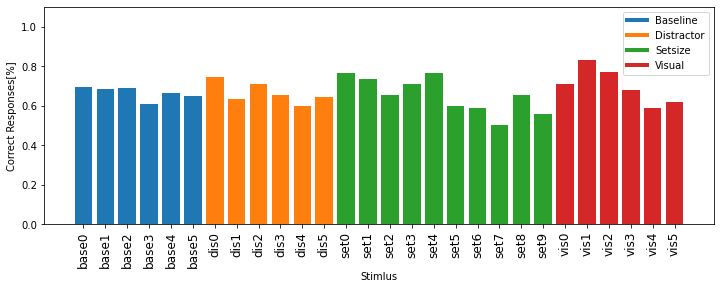

In [27]:
## Look at single stimuli
plt.figure(figsize=(12,4))
ss = df.groupby("Stimulus_ID")["Correct_Response"].sum() /df.groupby("Stimulus_ID")["Correct_Response"].size() 
col = ["tab:blue" for x in range(6)]
col.extend(["tab:orange" for x in range(6)])
col.extend(["tab:green" for x in range(10)])
col.extend(["tab:red" for x in range(6) ])
labels =["Baseline" for x in range(6)]
labels.extend(["Distractor" for x in range(6)])
labels.extend(["SetSize" for x in range(6)])
labels.extend(["Visual" for x in range(6)])
plt.bar(ss.index, ss, color = col)
plt.xticks(rotation=90, fontsize = 12)
plt.ylabel("Correct Responses[%]")
plt.xlabel("Stimlus")
plt.ylim(0,1.1)

custom_lines = [plt.Line2D([0], [0], color="tab:blue", lw=4),
                plt.Line2D([0], [0], color="tab:orange", lw=4),
                plt.Line2D([0], [0], color="tab:green", lw=4),
               plt.Line2D([0], [0], color="tab:red", lw=4)]
plt.legend(custom_lines, ["Baseline", "Distractor", "Setsize", "Visual"])
plt.show()

## Performance for valid and invalid pairs
Participants performed significantly better on stimuli pairs to be classifeid as valid than on those considered invalid. 

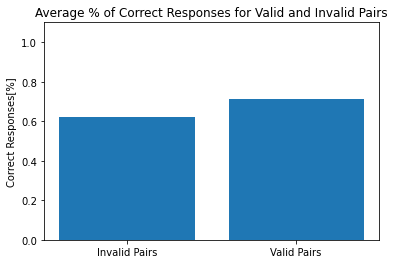

In [28]:
vi = df[df["Trial_Type"]=="categorize-html"]#.groupby("Associated")["Correct_Response"].sum() / df[df["Trial_Type"]=="categorize-html"].groupby("Associated")["Correct_Response"].size()


plt.bar(["Invalid Pairs","Valid Pairs"], [vi[vi["Associated"]== False]["Correct_Response"].mean(),vi[vi["Associated"]== True]["Correct_Response"].mean()])
#plt.errorbar(labels, x = vi[vi["Associated"]== False]["Correct_Response"].mean(),y = vi[vi["Associated"]== True]["Correct_Response"].mean(), yerr=c, fmt="o", color="k")
plt.ylim(0,1.1)
plt.ylabel("Correct Responses[%]")

plt.title("Average % of Correct Responses for Valid and Invalid Pairs")
plt.show()

In [29]:
x = vi[vi["Associated"]== True].groupby("Participant")["Correct_Response"].sum() / vi[vi["Associated"]== True].groupby("Participant")["Correct_Response"].size()
y = vi[vi["Associated"]== False].groupby("Participant")["Correct_Response"].sum() / vi[vi["Associated"]== False].groupby("Participant")["Correct_Response"].size()
print(scipy.stats.wilcoxon(x,y, mode = "approx"))

WilcoxonResult(statistic=239.5, pvalue=4.183835733430004e-05)


In [30]:
t = df[df["Trial_Type"]=="categorize-html"]
TP = len(t[(t["Key"]==70) & (t["Associated"]==True)]) / len(t)
FP = len(t[(t["Key"]==70) & (t["Associated"]==False)]) / len(t)
TN = len(t[(t["Key"]==74) & (t["Associated"]==False)]) / len(t)
FN = len(t[(t["Key"]==74) & (t["Associated"]==True)]) / len(t)

In [31]:
[TP, FP, TN, FN]

[0.35591397849462364,
 0.1881720430107527,
 0.3118279569892473,
 0.14408602150537633]

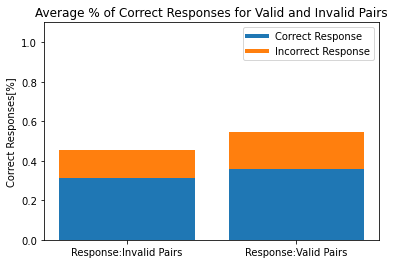

In [32]:
plt.bar(["Response:Invalid Pairs","Response:Valid Pairs"],[TN, TP])
plt.bar(["Response:Invalid Pairs","Response:Valid Pairs"],[FN, FP], bottom = [TN, TP])
#plt.errorbar(labels, x = vi[vi["Associated"]== False]["Correct_Response"].mean(),y = vi[vi["Associated"]== True]["Correct_Response"].mean(), yerr=c, fmt="o", color="k")
plt.ylim(0,1.1)
plt.ylabel("Correct Responses[%]")

plt.title("Average % of Correct Responses for Valid and Invalid Pairs")

custom_lines = [plt.Line2D([0], [0], color="tab:blue", lw=4),
                plt.Line2D([0], [0], color="tab:orange", lw=4)]
plt.legend(custom_lines, ["Correct Response", "Incorrect Response"])
plt.show()

# Did participants learn?

Contrast perfromance at the beginning and the end of learning.
## Performance of 2nd vs. 5th trial 
Significantly differs only for visual stimuli.

In [33]:
# first / last per condition 
def test_learning(condition):
    fl = df[df["Block"]==condition]
    if condition == "all":
        fl = df[df["Trial_Type"]=="categorize-html"]
    
    print(len(fl))
    first = fl[fl["Nr_Pres"]== 1].groupby("Participant")["Correct_Response"].sum() / fl[fl["Nr_Pres"]== 0].groupby("Participant")["Correct_Response"].size()
    last = fl[fl["Nr_Pres"]== 4].groupby("Participant")["Correct_Response"].sum() / fl[fl["Nr_Pres"]== 4].groupby("Participant")["Correct_Response"].size()
    print(scipy.stats.wilcoxon(first,last, mode = "approx"))

In [34]:
adjusted_p = 0.05/4
adjusted_p

0.0125

In [35]:
test_learning("Baseline")

1680
WilcoxonResult(statistic=195.5, pvalue=0.19675727620095151)


In [36]:
test_learning("Visual")

600
WilcoxonResult(statistic=16.0, pvalue=0.006751731330784412)


In [37]:
test_learning("Setsize")

900
WilcoxonResult(statistic=30.5, pvalue=0.8209374837557047)


In [38]:
test_learning("Distractor")

540
WilcoxonResult(statistic=8.5, pvalue=0.028189356302630857)


In [39]:
m_df = pd.DataFrame()
correct = df[df["Trial_Type"]=="categorize-html"].groupby(["Participant"])["Correct_Response"].sum() / df.groupby("Participant")["Correct_Response"].size()
#_df["trial_1"] = df[df["Trial_Type"]=="categorize-html"].groupby(["Participant"])["Correct_Response"]
above_correct = correct[correct > correct.median()]
below_correct = correct[correct <= correct.median()]

below_correct.index

Index(['debug3zEol', 'debug6LTBd', 'debug6hhbS', 'debug8eefY', 'debug8ksEC',
       'debug8rpnR', 'debugCAdsU', 'debugCB9uL', 'debugDGT1S', 'debugIG4lN',
       'debugJ8HgP', 'debugK5jRJ', 'debugL3TDu', 'debugO1ufP', 'debugS2Gq0',
       'debugXLBVg', 'debugXaBDO', 'debugZ3FfS', 'debugZKwsG', 'debugbBgvh',
       'debugbLQzK', 'debughLE3p', 'debugmIom4', 'debugmntMU', 'debugnvmBV',
       'debugr8kMb', 'debugtsLlv', 'debugysroH'],
      dtype='object', name='Participant')

## Compare high vs low performing participants

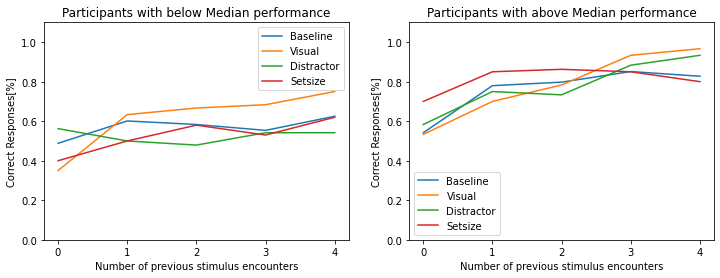

In [40]:
mask = df["Participant"].isin(below_correct.index)
b = df[mask]
mask = df["Participant"].isin(above_correct.index)
a = df[mask]
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
linedata = b.groupby(["Block","Nr_Pres"])["Correct_Response"].sum() / b.groupby(["Block", "Nr_Pres"])["Correct_Response"].size()
plt.title("Participants with below Median performance")
plt.plot([x for x in range(0,5)],linedata["Baseline"][:], label = "Baseline")
plt.plot([x for x in range(0,5)],linedata["Visual"][:], label = "Visual")
plt.plot([x for x in range(0,5)],linedata["Distractor"][:], label = "Distractor")
plt.plot([x for x in range(0,5)],linedata["Setsize"][:], label = "Setsize")
plt.legend()
plt.ylim(0,1.1)
plt.ylabel("Correct Responses[%]")
plt.xticks([0,1,2,3,4])        
plt.xlabel("Number of previous stimulus encounters")

plt.subplot(1,2,2)
linedata = a.groupby(["Block","Nr_Pres"])["Correct_Response"].sum() / a.groupby(["Block", "Nr_Pres"])["Correct_Response"].size()
plt.title("Participants with above Median performance")
plt.plot([x for x in range(0,5)],linedata["Baseline"][:], label = "Baseline")
plt.plot([x for x in range(0,5)],linedata["Visual"][:], label = "Visual")
plt.plot([x for x in range(0,5)],linedata["Distractor"][:], label = "Distractor")
plt.plot([x for x in range(0,5)],linedata["Setsize"][:], label = "Setsize")
plt.legend()
plt.ylim(0,1.1)
plt.ylabel("Correct Responses[%]")
plt.xticks([0,1,2,3,4])        
plt.xlabel("Number of previous stimulus encounters")
#plt.suptitle(labels[1]+" Condition", fontsize = 16)
plt.show()

plt.show()

## Learning Curves for each Particpant

debug6LTBd


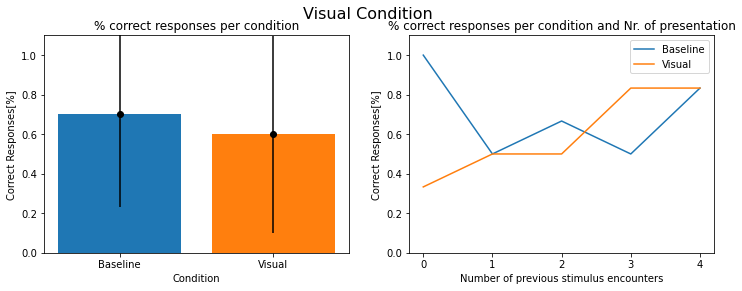

debugmntMU


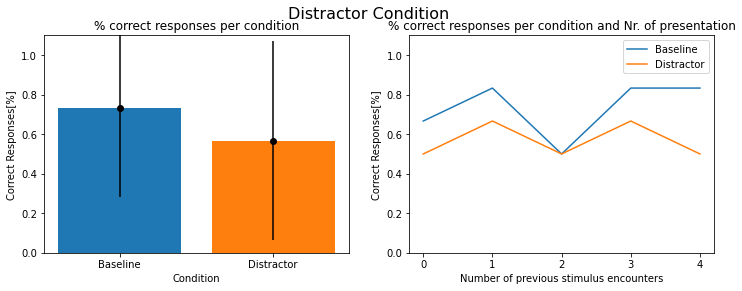

debugJ8HgP


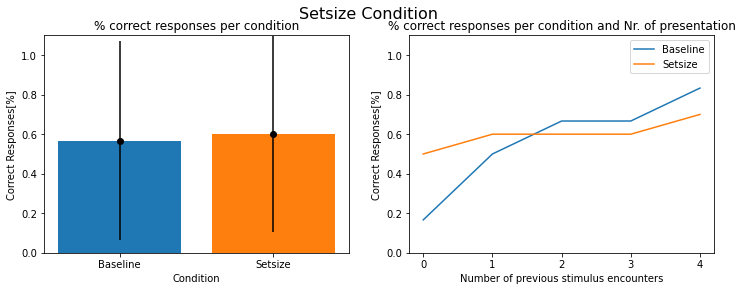

debugtsLlv


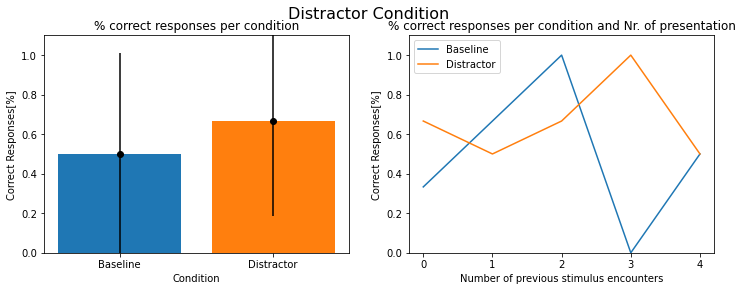

debugZKwsG


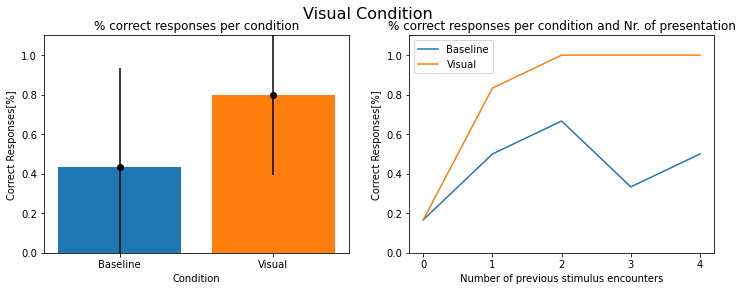

debugO1ufP


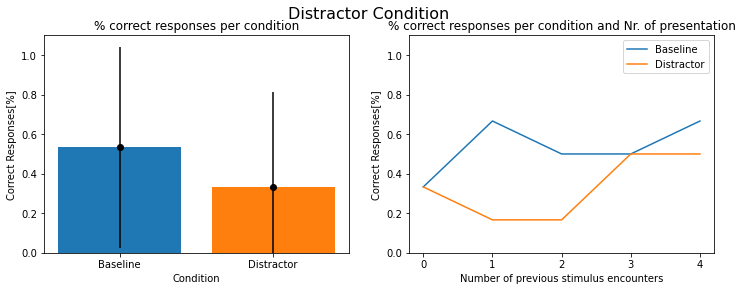

debugZ3FfS


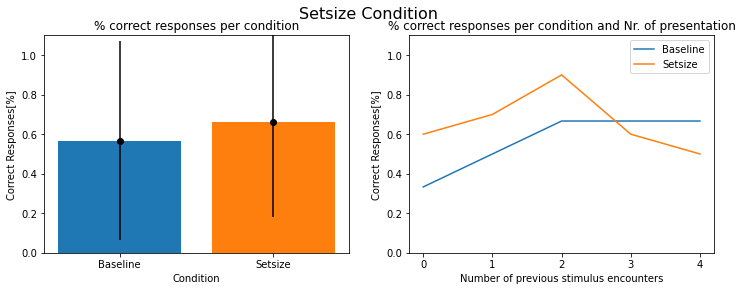

debug3zEol


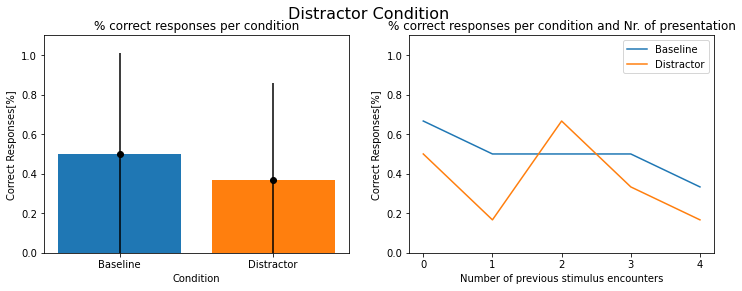

debugjWhOd


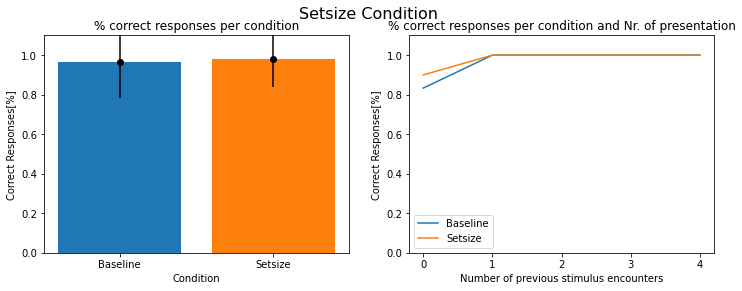

debug8rpnR


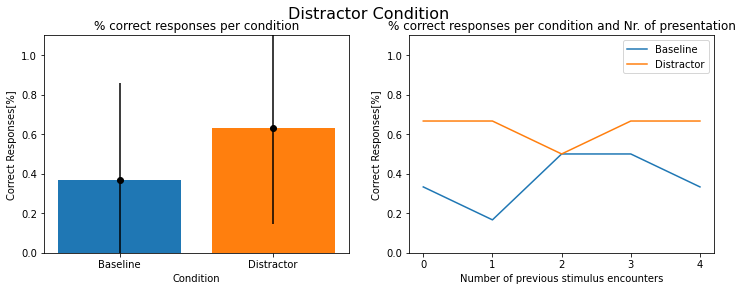

debugauJFM


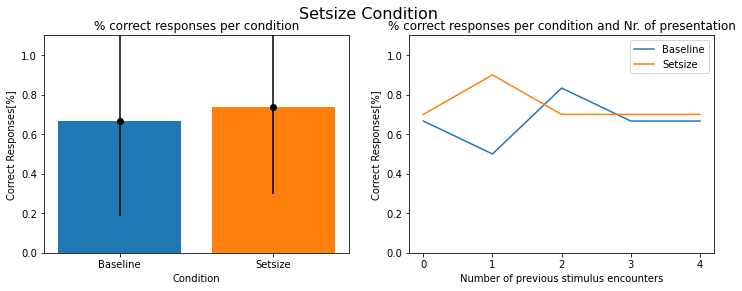

debugnvmBV


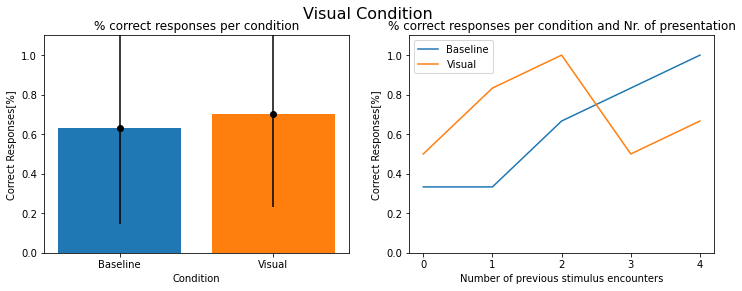

debugoENMp


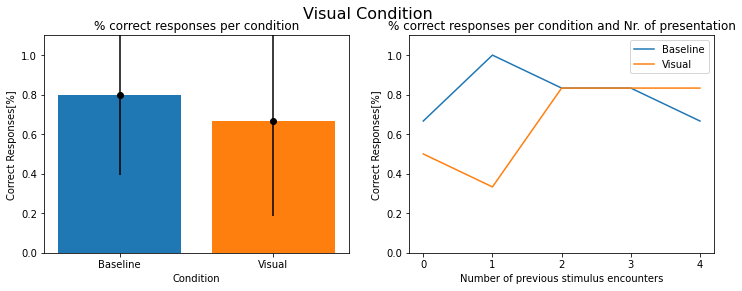

debughLE3p


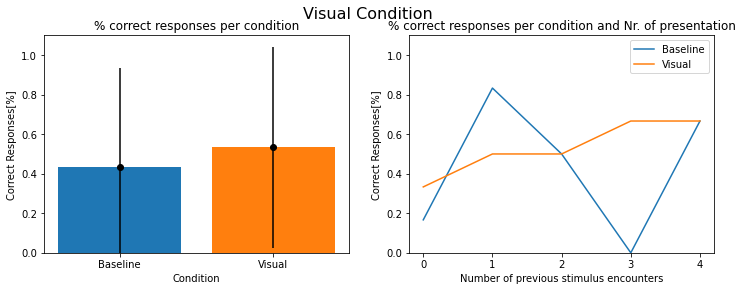

debugHAXLZ


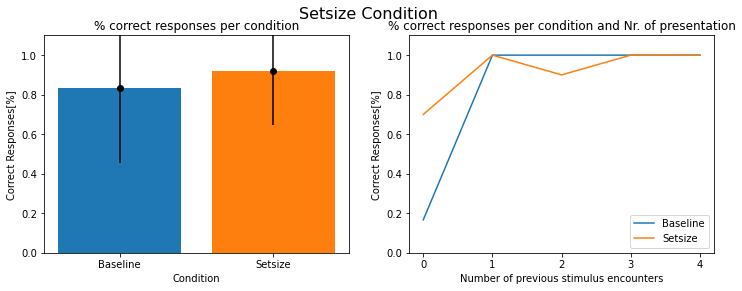

debugheKcZ


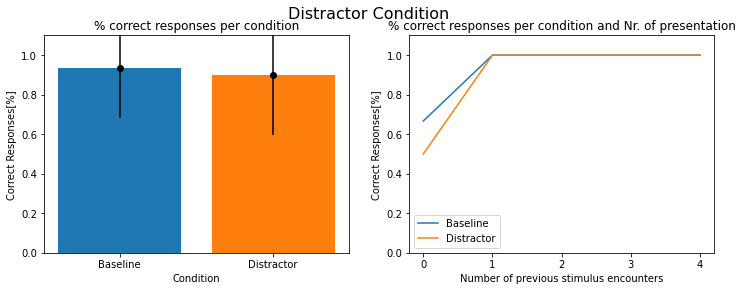

debugMzuqV


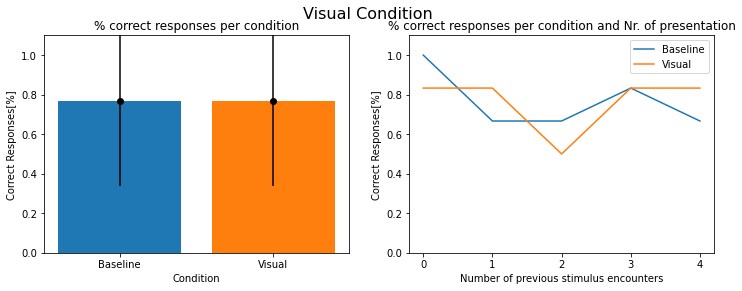

debugIG4lN


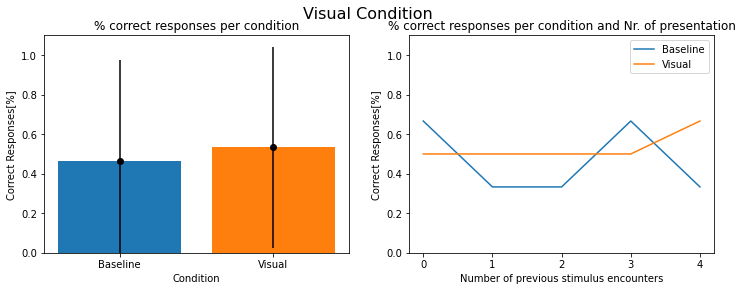

debugr8kMb


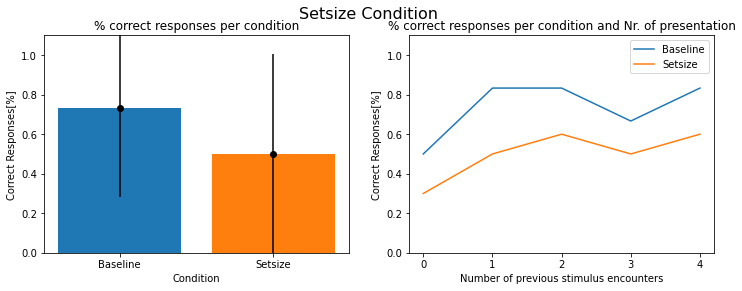

debugeAYIh


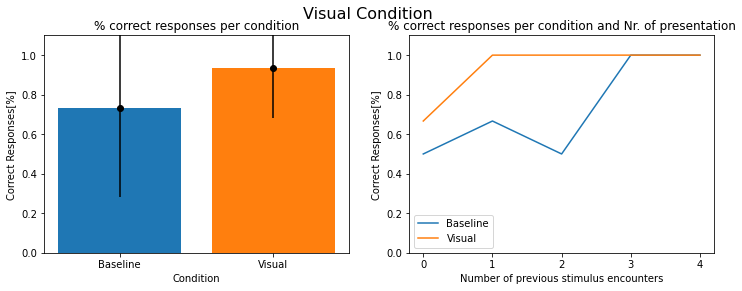

debugsgdoo


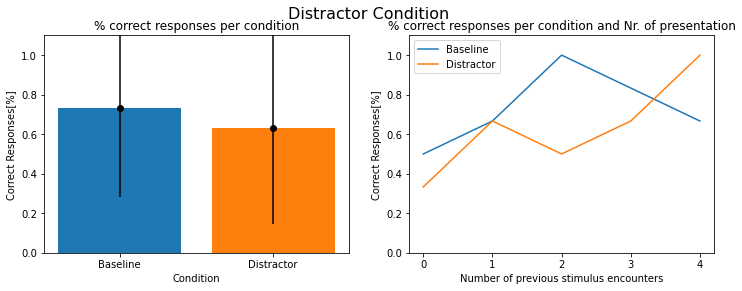

debugmIom4


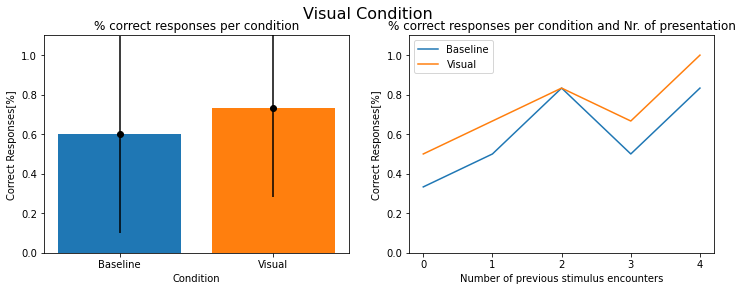

debugCB9uL


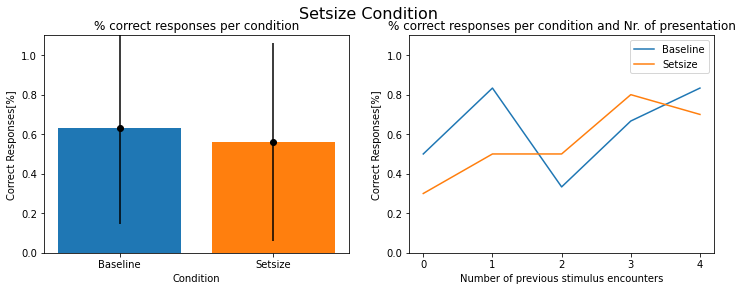

debugDGT1S


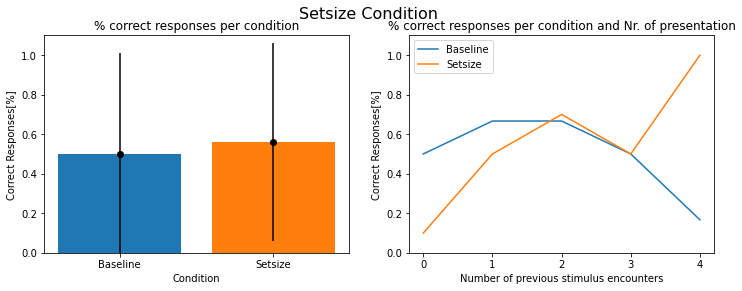

debugL3TDu


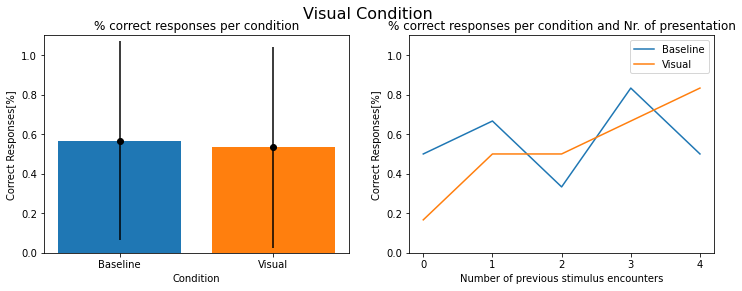

debugXztcD


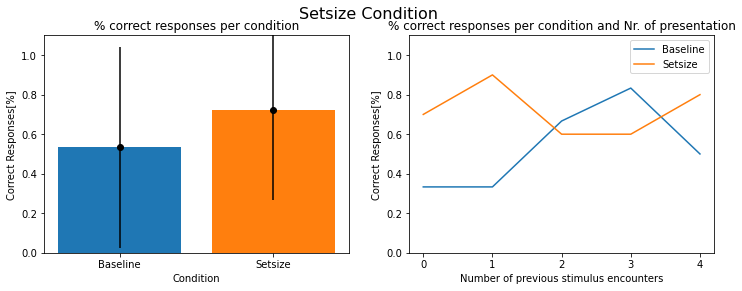

debuglyQa8


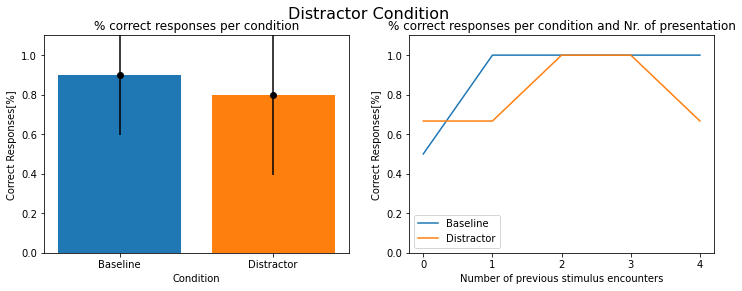

debugbLQzK


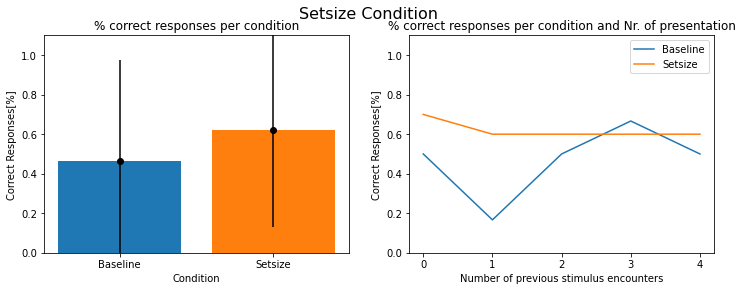

debugphxrb


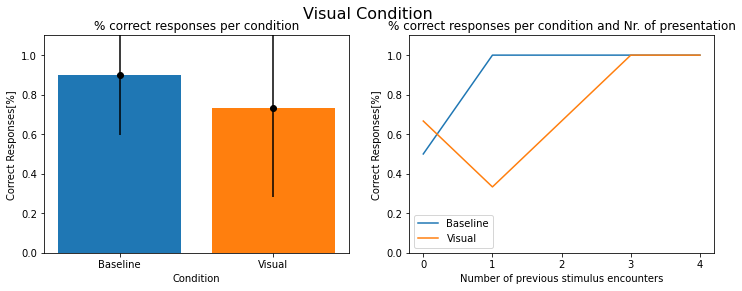

debugFIgHf


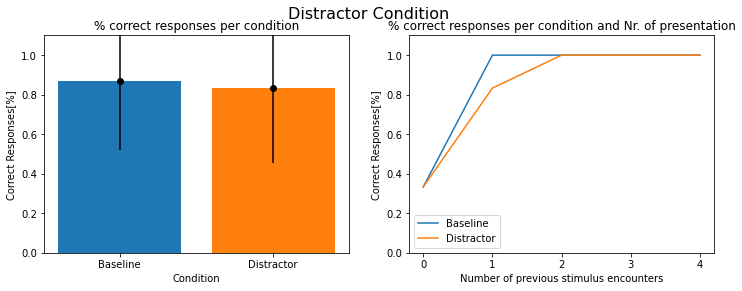

debugBBjRB


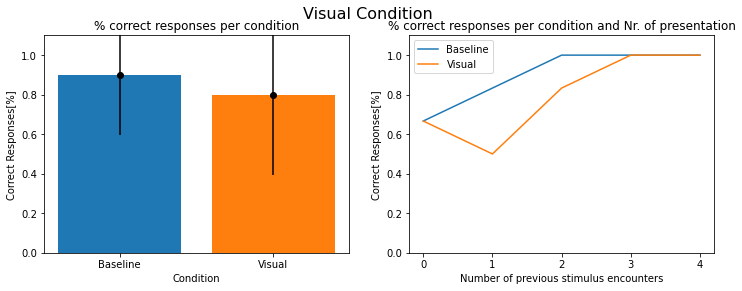

debugCqVI5


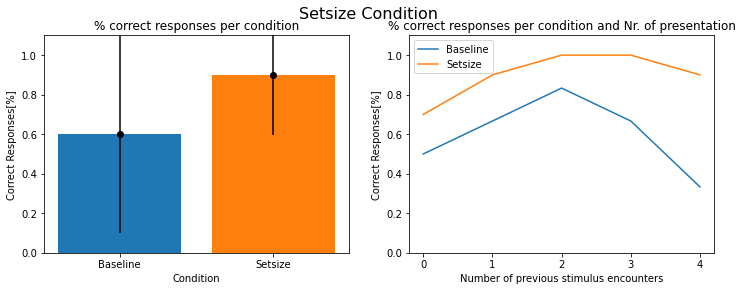

debugK5jRJ


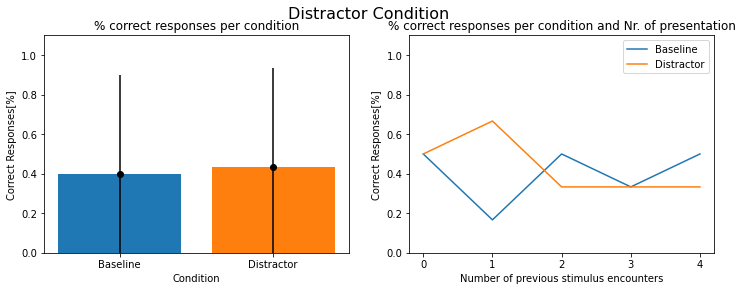

debug92pLj


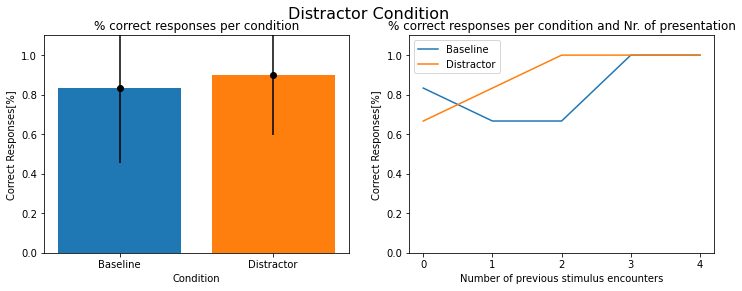

debug8ksEC


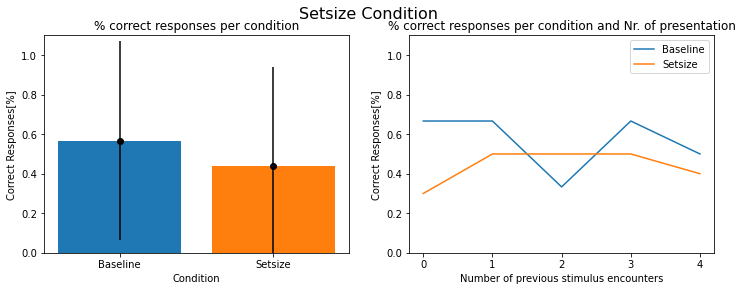

debugYxgGr


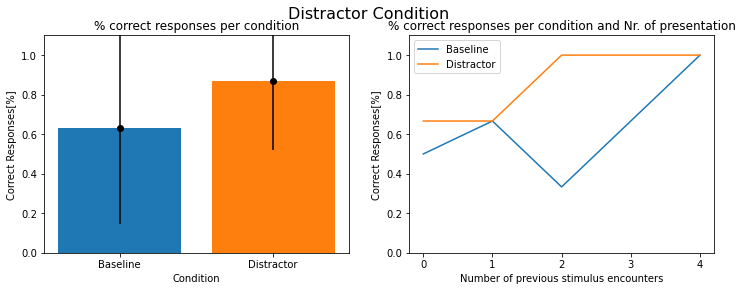

debugBw6r6


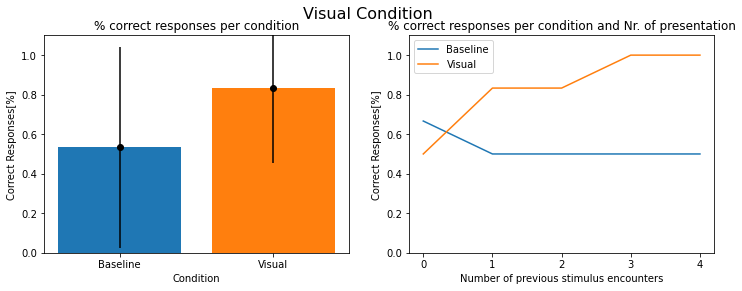

debugReKiR


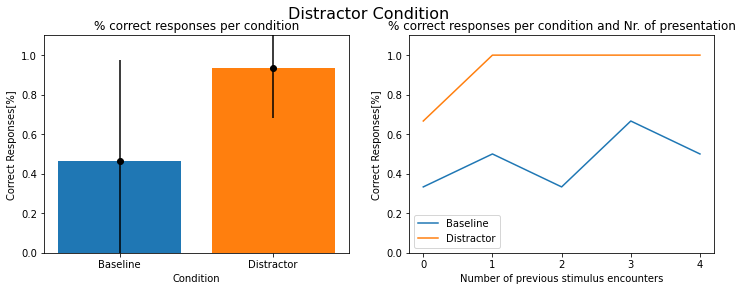

debugD4pn1


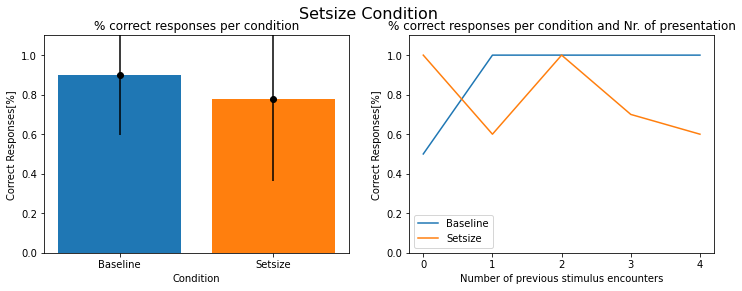

debugbBgvh


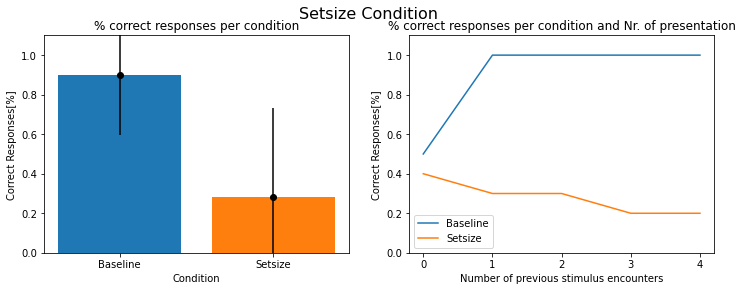

debugDQvEn


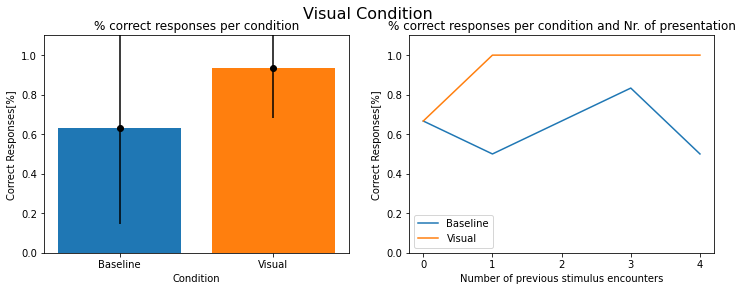

debugS2Gq0


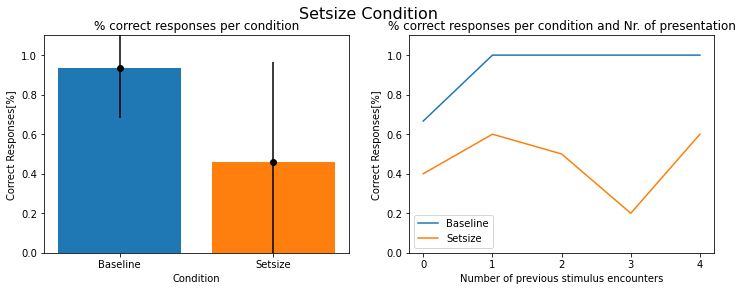

debugCAdsU


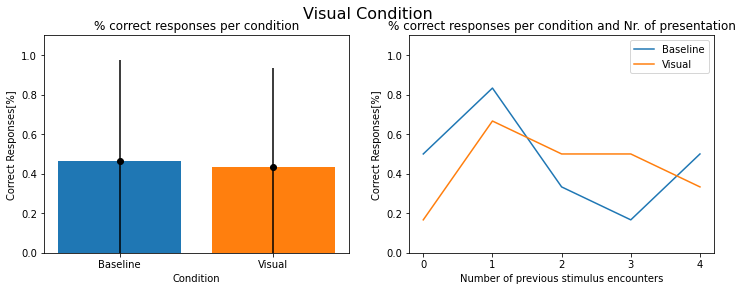

debugysroH


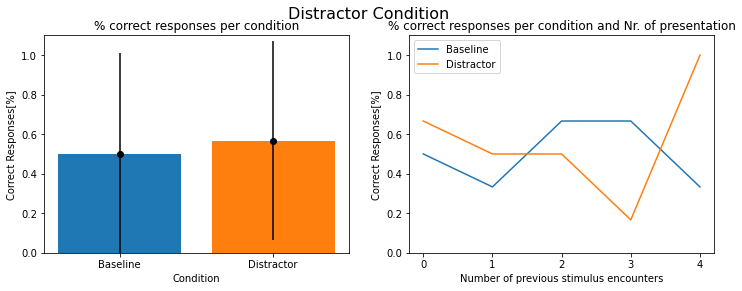

debug8eefY


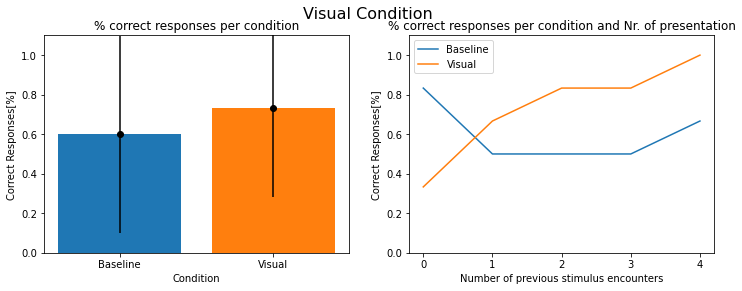

debugM0F17


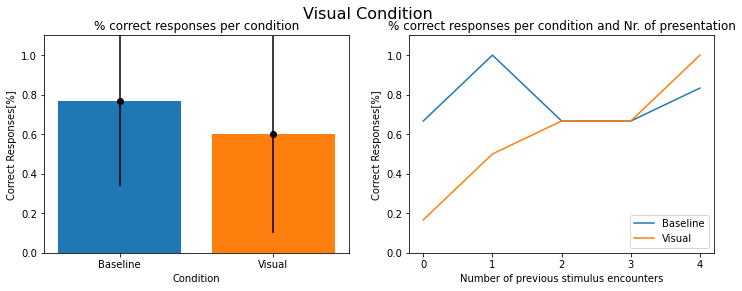

debug6hhbS


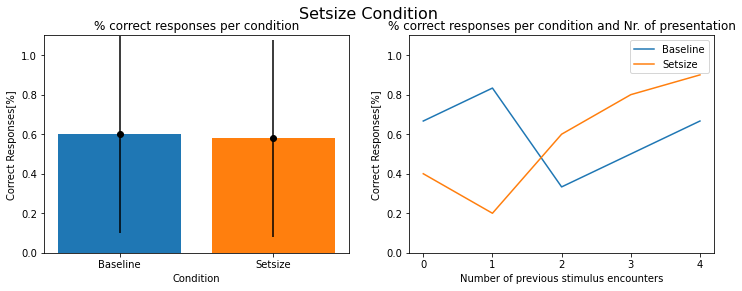

debug4N7sZ


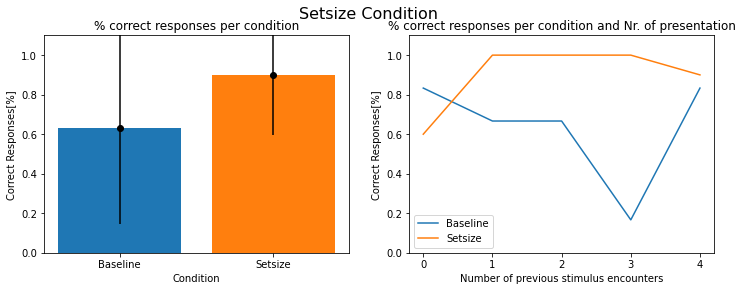

debughKAJM


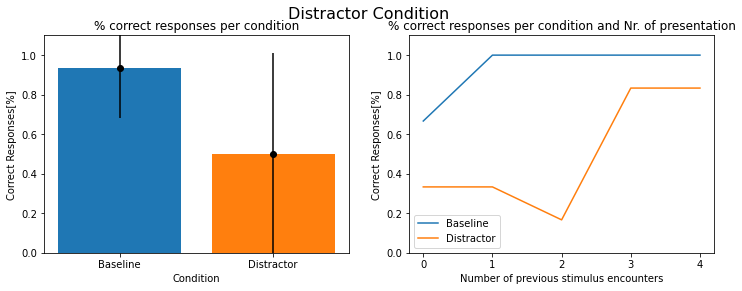

debugfO7Bo


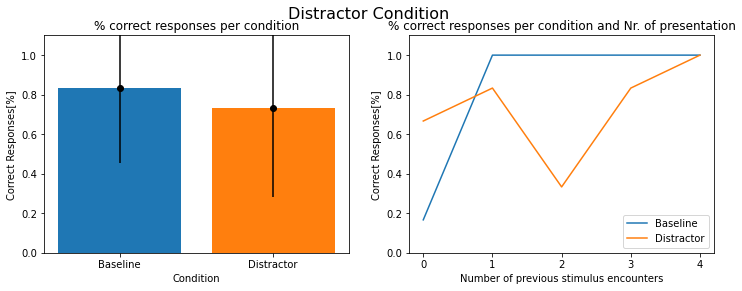

debugvc3pB


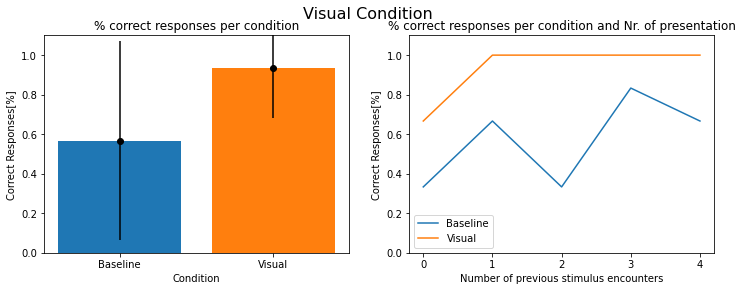

debugXLBVg


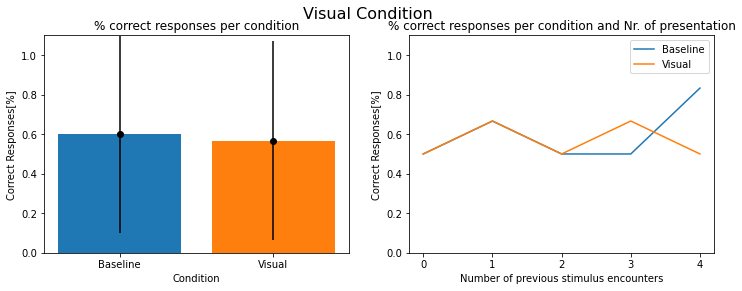

debugUgTKf


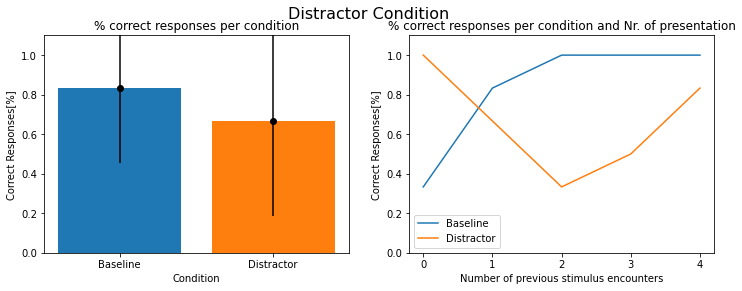

debugXaBDO


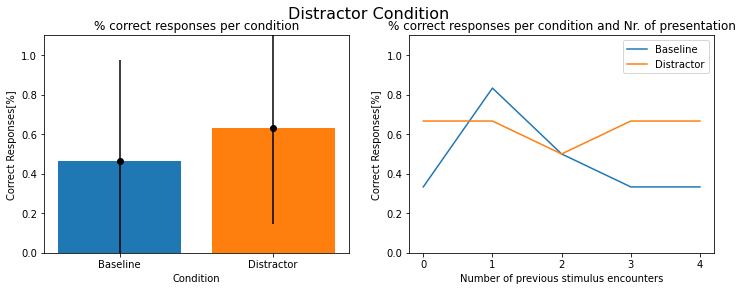

debugZjPfV


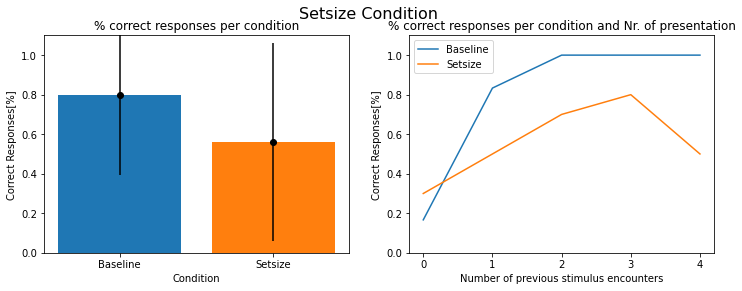

debugCWQHS


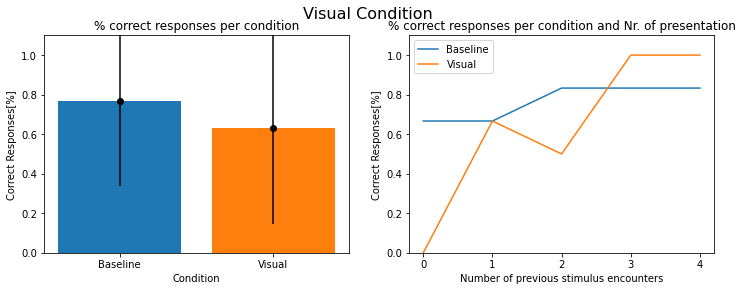

In [41]:
def basic_plots_pp():
    plt.figure(figsize=(12,4))
    condition = list(df_p["Condition"])[0]
    labels = [["Baseline", "Visual"],["Baseline", "Distractor"],["Baseline", "Setsize"]][condition]
    c0 = df_p
    plt.subplot(1,2,1)
    plt.title("% correct responses per condition")
    plt.bar(labels, [c0[c0["Block"]==labels[0]]["Correct_Response"].mean(),c0[c0["Block"]==labels[1]]["Correct_Response"].mean()], color=['tab:blue', 'tab:orange'])
    plt.errorbar(labels, [c0[c0["Block"]==labels[0]]["Correct_Response"].mean(),c0[c0["Block"]==labels[1]]["Correct_Response"].mean()], yerr=[c0[c0["Block"]==labels[0]]["Correct_Response"].std(),c0[c0["Block"]==labels[1]]["Correct_Response"].std()], fmt="o", color="k")
    plt.ylim(0,1.1)
    plt.ylabel("Correct Responses[%]")
    plt.xlabel("Condition")
    plt.subplot(1,2,2)
    linedata = c0.groupby(["Block", "Nr_Pres"])["Correct_Response"].sum() / c0.groupby(["Block", "Nr_Pres"])["Correct_Response"].size()
    plt.title("% correct responses per condition and Nr. of presentation")
    plt.plot([x for x in range(0,5)],linedata[labels[0]][:], label = labels[0])
    plt.plot([x for x in range(0,5)],linedata[labels[1]][:], label = labels[1])
    plt.legend()
    plt.ylim(0,1.1)
    plt.ylabel("Correct Responses[%]")
    plt.xticks([0,1,2,3,4])        
    plt.xlabel("Number of previous stimulus encounters")
    plt.suptitle(labels[1]+" Condition", fontsize = 16)
    plt.show()

for participant in df["Participant"].unique():
    print(participant)
    df_p = df[df["Participant"]==participant]
    basic_plots_pp()

In [42]:
#TODO get percentage of people failing to learn 
df[df["Participant"]=="debugeAYIh"]

,Participant,Condition,TrialId,Trial_Type,Trialtime,Key,ResponseTime,Correct_Response,Block,Associated,Stimulus_ID,RT,Nr_Pres
1393,debugeAYIh,0,0,html-keyboard-response,2021-08-04 08:43:09.172,13,2601,None,None,None,None,NaN,133
1394,debugeAYIh,0,1,html-keyboard-response,2021-08-04 08:44:51.030,13,104459,None,None,None,None,NaN,134
1395,debugeAYIh,0,2,html-keyboard-response,2021-08-04 08:45:18.185,13,131613,None,None,None,None,NaN,135
1396,debugeAYIh,0,3,categorize-html,2021-08-04 08:46:05.019,70,178448,False,Baseline,False,base4,39883.0,0
1397,debugeAYIh,0,4,categorize-html,2021-08-04 08:46:11.153,70,184582,True,Baseline,True,base1,2685.0,0
1398,debugeAYIh,0,5,categorize-html,2021-08-04 08:46:26.415,74,199844,True,Baseline,False,base5,13548.0,0
1399,debugeAYIh,0,6,categorize-html,2021-08-04 08:46:31.661,70,205089,True,Baseline,True,base0,4060.0,0
1400,debugeAYIh,0,7,categorize-html,2021-08-04 08:46:36.277,74,209705,False,Baseline,True,base2,3377.0,0
1401,debugeAYIh,0,8,categorize-html,2021-08-04 08:46:41.653,70,215081,False,Baseline,False,base3,3504.0,0
1402,debugeAYIh,0,9,categorize-html,2021-08-04 08:46:56.237,70,229666,False,Baseline,False,base5,12891.0,1


In [43]:
df["RT"].mean()

3536.6559139784945

In [44]:
mask = df["Participant"].isin(below_correct.index)
b = df[mask]
mask = df["Participant"].isin(above_correct.index)
a = df[mask]

b["RT"].mean()

2547.567021276596

(array([1.666e+03, 1.137e+03, 4.480e+02, 1.760e+02, 9.900e+01, 6.400e+01,
        3.100e+01, 2.300e+01, 1.700e+01, 1.100e+01, 9.000e+00, 7.000e+00,
        5.000e+00, 4.000e+00, 2.000e+00, 1.000e+00, 4.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00]),
 array([2.40000e+01, 1.97310e+03, 3.92220e+03, 5.87130e+03, 7.82040e+03,
        9.76950e+03, 1.17186e+04, 1.36677e+04, 1.56168e+04, 1.75659e+04,
        1.95150e+04, 2.14641e+04, 2.34132e+04, 2.53623e+04, 2.73114e+04,
        2.92605e+04, 3.12096e+04, 3.31587e+04, 3.51078e+04, 3.70569e+04,
        3.90060e+04, 4.09551e+04, 4.29042e+04, 4.48533e+04, 4.68024e+04,
        4.8

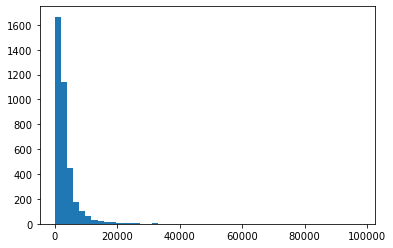

In [45]:
x,y = np.histogram(df[df["Trial_Type"]=="categorize-html"]["RT"], bins = 50 ,density = False)
plt.hist(df[df["Trial_Type"]=="categorize-html"]["RT"],bins = y)

In [46]:
df[df["Trial_Type"]=="categorize-html"]["RT"].min()

24.0